In [1]:
!pip install rioxarray geopandas rasterio pyproj pystac_client planetary_computer pystac

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.8/206.8 kB 7.8 MB/s eta 0:00:00


In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows  
from rasterio import features  
from rasterio import warp
from rasterio.warp import transform_bounds 
from rasterio.windows import from_bounds 

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
from tqdm import tqdm

print('done')

done


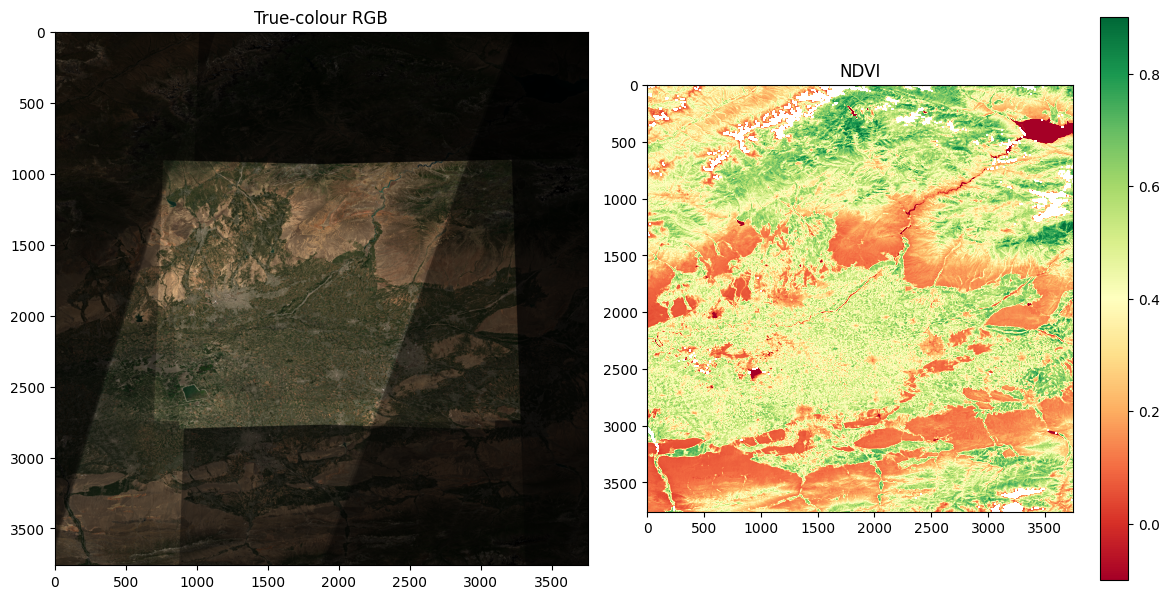

In [3]:
tiff_path_fergana = "/kaggle/input/ghfgh/tensorflow2/default/1/Sentinel2_fergana_WeightedMosaic_mean.tif"
tiff_path_orenburg = "/kaggle/input/ghfgh/tensorflow2/default/1/Sentinel2_orenburg_WeightedMosaic_median.tif"

with rasterio.open(tiff_path_fergana) as src:
    # read RGB + NIR (adjust band numbers to your stack)
    red   = src.read(4).astype('float32')  # B04
    green = src.read(3).astype('float32')  # B03
    blue  = src.read(2).astype('float32')  # B02
    nir   = src.read(8).astype('float32')  # B08  (example)

    # scale 0–1 for display
    def scale(arr):
        arr = np.clip(arr * 0.0001, 0, 0.35)  # 0–35 % reflectance
        return (arr - arr.min()) / (arr.max() - arr.min())

    rgb = np.dstack([scale(red), scale(green), scale(blue)])
    ndvi = (nir - red) / (nir + red)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(rgb)
ax[0].set_title("True-colour RGB")

im = ax[1].imshow(ndvi, cmap='RdYlGn', vmin=-0.1, vmax=0.9)
ax[1].set_title("NDVI")
fig.colorbar(im, ax=ax[1])
plt.tight_layout(); plt.show()

In [4]:
import rioxarray as rxr

da = rxr.open_rasterio(tiff_path_fergana)
band_names = list(da.band.values)   # or list(da.attrs['long_name']) if present
print(band_names)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


In [5]:
print(rxr.open_rasterio(tiff_path_fergana).rio.crs)

None


In [6]:
# === Updated cell: map_satellite_data with derived indices & ring stats ===
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
from rasterio.features import geometry_mask
from rasterio.windows import Window
import rioxarray as rxr
import xarray as xr
from shapely.geometry import Point
from tqdm import tqdm
from pyproj import Transformer
import warnings


def map_satellite_data(tiff_path, df, rings_m=(90, 270, 500), savi_L=0.5):
    """
    Memory-efficient version that processes local clips instead of reprojecting entire raster
    
    tiff_path : GeoTIFF in EPSG:4326 (lat/lon degrees)
    df        : DataFrame with 'Latitude', 'Longitude' (EPSG:4326)
    rings_m   : buffer radii in metres
    savi_L    : soil adjustment factor for SAVI/OSAVI (default 0.5)
    returns   : df with pixel values + annular-ring stats for raw bands and derived indices
    """
    # -- open raster and label bands
    da = rxr.open_rasterio(tiff_path, masked=True)
    da = da.rio.write_crs('EPSG:4326')
    band_map = {
        1: 'B01', 2: 'B02', 3: 'B03', 4: 'B04', 5: 'B05',
        6: 'B06', 7: 'B07', 8: 'B08', 9: 'B8A', 10: 'B11',
        11: 'B12', 12: 'SCL', 13: 'WVP', 14: 'AOT'
    }
    band_names = [band_map.get(int(b), f"band{int(b)}") for b in da.band.values]
    name_to_idx = {name: i for i, name in enumerate(band_names)}

    # helper: check if required bands exist
    def has(*names):
        return all(n in name_to_idx for n in names)

    # === compute point (pixel) values first ===
    mean_lon = float(df.Longitude.mean())
    mean_lat = float(df.Latitude.mean())
    utm_zone = int((mean_lon + 180) / 6) + 1
    utm_crs = f'EPSG:326{utm_zone:02d}' if mean_lat >= 0 else f'EPSG:327{utm_zone:02d}'
    print(f"Using CRS: {utm_crs} for coordinates around {mean_lat:.2f}°N, {mean_lon:.2f}°E")

    samples = da.sel(
        x=xr.DataArray(df.Longitude.values, dims='point'),
        y=xr.DataArray(df.Latitude.values, dims='point'),
        method='nearest'
    )
    pixel_df = pd.DataFrame(samples.values.T, columns=band_names)

    # --- helper: safe ratios for pandas Series ---
    def _sr_ratio(num, den):
        denom = num + den
        out = (num - den) / denom
        out[~np.isfinite(out)] = np.nan
        out[denom == 0] = np.nan
        return out

    # Derived index columns (per-point pixels)
    derived_pixel = {}
    if has('B08', 'B04'):  # NDVI, SAVI, MSAVI, EVI/EVI2, OSAVI
        NIR = pixel_df['B08']
        RED = pixel_df['B04']
        derived_pixel['NDVI'] = _sr_ratio(NIR, RED)
        # SAVI / OSAVI
        derived_pixel['SAVI'] = (1 + savi_L) * (NIR - RED) / (NIR + RED + savi_L)
        derived_pixel['OSAVI'] = (1 + savi_L) * (NIR - RED) / (NIR + RED + 0.16)
        # MSAVI
        derived_pixel['MSAVI'] = 0.5 * (2 * NIR + 1 - np.sqrt((2 * NIR + 1) ** 2 - 8 * (NIR - RED)))
        # EVI / EVI2 (guard zeros)
        if has('B02'):
            BLUE = pixel_df['B02']
            derived_pixel['EVI'] = 2.5 * (NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1.0)
        derived_pixel['EVI2'] = 2.5 * (NIR - RED) / (NIR + 2.4 * RED + 1.0)

    if has('B08', 'B03'):
        derived_pixel['GNDVI'] = _sr_ratio(pixel_df['B08'], pixel_df['B03'])
        # NDWI (McFeeters: Green vs NIR)
        derived_pixel['NDWI'] = _sr_ratio(pixel_df['B03'], pixel_df['B08'])
        # GCI
        g = pixel_df['B03']
        gci = (pixel_df['B08'] / g) - 1
        gci[~np.isfinite(gci)] = np.nan
        derived_pixel['GCI'] = gci

    if has('B08', 'B05'):
        derived_pixel['NDRE'] = _sr_ratio(pixel_df['B08'], pixel_df['B05'])
    if has('B8A', 'B05'):
        derived_pixel['NDRE2'] = _sr_ratio(pixel_df['B8A'], pixel_df['B05'])

    if has('B08', 'B11'):
        derived_pixel['NDMI'] = _sr_ratio(pixel_df['B08'], pixel_df['B11'])  # moisture
        derived_pixel['NDBI'] = _sr_ratio(pixel_df['B11'], pixel_df['B08'])  # built-up inverse proxy
    if has('B08', 'B12'):
        derived_pixel['NBR'] = _sr_ratio(pixel_df['B08'], pixel_df['B12'])   # burn/dryness

    if has('B11', 'B04', 'B08', 'B02'):
        swir1 = pixel_df['B11']; red = pixel_df['B04']; nir = pixel_df['B08']; blue = pixel_df['B02']
        num = (swir1 + red) - (nir + blue)
        den = (swir1 + red) + (nir + blue)
        bsi = num / den
        bsi[~np.isfinite(bsi)] = np.nan
        derived_pixel['BSI'] = bsi

    if has('B03', 'B04', 'B02'):
        g = pixel_df['B03']; r = pixel_df['B04']; b = pixel_df['B02']
        den = (g + r - b)
        vari = (g - r) / den
        vari[(den == 0) | ~np.isfinite(vari)] = np.nan
        derived_pixel['VARI'] = vari

    pixel_idx_df = pd.DataFrame(derived_pixel)
    out = pd.concat([df.reset_index(drop=True),
                     pixel_df.reset_index(drop=True),
                     pixel_idx_df.reset_index(drop=True)], axis=1)

    # === per-point local reprojection & ring stats ===
    results_list = []
    max_buffer = max(rings_m)

    # crude degrees-per-meter at mean latitude (OK for local clip bounds)
    deg_per_meter = 1.0 / (111000 * max(0.1, np.cos(np.radians(mean_lat))))
    buffer_deg = max_buffer * deg_per_meter * 2  # generous clip

    print(f"Processing {len(df)} points with local reprojection...")

    # convenience: list of index names to compute
    index_names = []
    if has('B08', 'B04'):
        index_names += ['NDVI', 'SAVI', 'MSAVI', 'EVI2', 'OSAVI']
        if has('B02'):
            index_names += ['EVI']
    if has('B08', 'B03'):
        index_names += ['GNDVI', 'NDWI', 'GCI']
    if has('B08', 'B05'):
        index_names += ['NDRE']
    if has('B8A', 'B05'):
        index_names += ['NDRE2']
    if has('B08', 'B11'):
        index_names += ['NDMI', 'NDBI']
    if has('B08', 'B12'):
        index_names += ['NBR']
    if has('B11', 'B04', 'B08', 'B02'):
        index_names += ['BSI']
    if has('B03', 'B04', 'B02'):
        index_names += ['VARI']

    # ring computation
    for idx, (lat, lon) in enumerate(tqdm(zip(df.Latitude, df.Longitude),
                                          total=len(df), desc="Processing points")):
        point_data = {}
        try:
            # clip bounds in source CRS
            clip_bounds = (lon - buffer_deg, lat - buffer_deg, lon + buffer_deg, lat + buffer_deg)
            rb = da.rio.bounds()
            clip_bounds = (max(clip_bounds[0], rb[0]), max(clip_bounds[1], rb[1]),
                           min(clip_bounds[2], rb[2]), min(clip_bounds[3], rb[3]))
            if (clip_bounds[0] >= clip_bounds[2]) or (clip_bounds[1] >= clip_bounds[3]):
                # outside raster
                for r_prev, r_curr in zip([0] + list(rings_m)[:-1], rings_m):
                    for band in band_names + index_names:
                        suffix = f"_{r_prev}-{r_curr}m"
                        for stat in ("max", "min", "mean", "std"):
                            point_data[f"{band}_{stat}{suffix}"] = np.nan
                results_list.append(point_data)
                continue

            # local clip -> UTM reprojection
            da_local = da.rio.clip_box(*clip_bounds)
            if da_local.sizes['x'] == 0 or da_local.sizes['y'] == 0:
                for r_prev, r_curr in zip([0] + list(rings_m)[:-1], rings_m):
                    for band in band_names + index_names:
                        suffix = f"_{r_prev}-{r_curr}m"
                        for stat in ("max", "min", "mean", "std"):
                            point_data[f"{band}_{stat}{suffix}"] = np.nan
                results_list.append(point_data)
                continue

            da_local_utm = da_local.rio.reproject(utm_crs)

            # nodata per-band (may be tuple or scalar)
            nodatas = getattr(da_local_utm, "nodatavals", None)
            nodata_by_idx = {}
            if nodatas is not None and len(nodatas) == da_local_utm.sizes.get('band', 1):
                nodata_by_idx = {i: nodatas[i] for i in range(len(nodatas))}
            else:
                # fallback: single nodata
                nd_single = getattr(da_local_utm, "rio", None)
                nd_single = nd_single.nodata if nd_single is not None else None
                nodata_by_idx = {i: nd_single for i in range(len(band_names))}

            # prepare masked band arrays (nodata masked, no ring mask yet)
            band_arrays = {}
            for bname, bidx in name_to_idx.items():
                arr = da_local_utm.values[bidx].astype('float32', copy=False)
                if nodata_by_idx.get(bidx) is not None:
                    m = (arr == nodata_by_idx[bidx])
                    band_arrays[bname] = np.ma.array(arr, mask=m)
                else:
                    band_arrays[bname] = np.ma.array(arr, mask=np.zeros_like(arr, dtype=bool))

            # helper masked ratio
            def ma_ratio(a, b):
                # a,b are masked arrays; denom mask if zero
                denom = a + b
                zero = np.isclose(denom.filled(0), 0.0)
                denom_mask = np.ma.getmaskarray(denom) | zero
                res = np.ma.array((a - b) / denom, mask=denom_mask)
                return res

            # precompute derived index rasters (masked, no ring mask yet)
            idx_arrays = {}

            if 'NDVI' in index_names:
                idx_arrays['NDVI'] = ma_ratio(band_arrays['B08'], band_arrays['B04'])
            if 'SAVI' in index_names:
                nir, red = band_arrays['B08'], band_arrays['B04']
                idx_arrays['SAVI'] = (1 + savi_L) * (nir - red) / (nir + red + savi_L)
            if 'OSAVI' in index_names:
                nir, red = band_arrays['B08'], band_arrays['B04']
                idx_arrays['OSAVI'] = (1 + savi_L) * (nir - red) / (nir + red + 0.16)
            if 'MSAVI' in index_names:
                nir, red = band_arrays['B08'], band_arrays['B04']
                idx_arrays['MSAVI'] = 0.5 * (2 * nir + 1 - np.ma.sqrt((2 * nir + 1) ** 2 - 8 * (nir - red)))
            if 'EVI' in index_names and has('B02', 'B04', 'B08'):
                nir, red, blue = band_arrays['B08'], band_arrays['B04'], band_arrays['B02']
                idx_arrays['EVI'] = 2.5 * (nir - red) / (nir + 6 * red - 7.5 * blue + 1.0)
            if 'EVI2' in index_names:
                nir, red = band_arrays['B08'], band_arrays['B04']
                idx_arrays['EVI2'] = 2.5 * (nir - red) / (nir + 2.4 * red + 1.0)
            if 'GNDVI' in index_names:
                idx_arrays['GNDVI'] = ma_ratio(band_arrays['B08'], band_arrays['B03'])
            if 'NDWI' in index_names:
                idx_arrays['NDWI'] = ma_ratio(band_arrays['B03'], band_arrays['B08'])  # McFeeters
            if 'GCI' in index_names:
                g = band_arrays['B03']
                idx = (band_arrays['B08'] / g) - 1
                idx.mask |= ~np.isfinite(idx)
                idx_arrays['GCI'] = idx
            if 'NDRE' in index_names:
                idx_arrays['NDRE'] = ma_ratio(band_arrays['B08'], band_arrays['B05'])
            if 'NDRE2' in index_names:
                idx_arrays['NDRE2'] = ma_ratio(band_arrays['B8A'], band_arrays['B05'])
            if 'NDMI' in index_names:
                idx_arrays['NDMI'] = ma_ratio(band_arrays['B08'], band_arrays['B11'])
            if 'NDBI' in index_names:
                idx_arrays['NDBI'] = ma_ratio(band_arrays['B11'], band_arrays['B08'])
            if 'NBR' in index_names:
                idx_arrays['NBR'] = ma_ratio(band_arrays['B08'], band_arrays['B12'])
            if 'BSI' in index_names and has('B11', 'B04', 'B08', 'B02'):
                swir1, red, nir, blue = band_arrays['B11'], band_arrays['B04'], band_arrays['B08'], band_arrays['B02']
                num = (swir1 + red) - (nir + blue)
                den = (swir1 + red) + (nir + blue)
                zero = np.isclose(den.filled(0), 0.0)
                idx = num / den
                idx.mask |= zero | ~np.isfinite(idx)
                idx_arrays['BSI'] = idx
            if 'VARI' in index_names and has('B03', 'B04', 'B02'):
                g, r, b = band_arrays['B03'], band_arrays['B04'], band_arrays['B02']
                den = (g + r - b)
                zero = np.isclose(den.filled(0), 0.0)
                idx = (g - r) / den
                idx.mask |= zero | ~np.isfinite(idx)
                idx_arrays['VARI'] = idx

            # transformer and geometry in UTM
            transformer = Transformer.from_crs('EPSG:4326', utm_crs, always_xy=True)
            x_m, y_m = transformer.transform(lon, lat)
            point_geom = Point(x_m, y_m)

            # compute stats per ring for raw bands + indices
            for r_prev, r_curr in zip([0] + list(rings_m)[:-1], rings_m):
                try:
                    outer_buffer = point_geom.buffer(r_curr)
                    inner_buffer = point_geom.buffer(r_prev) if r_prev > 0 else Point()
                    ring = outer_buffer.difference(inner_buffer)

                    ring_mask = geometry_mask(
                        [ring],
                        transform=da_local_utm.rio.transform(),
                        invert=True,
                        out_shape=(da_local_utm.sizes['y'], da_local_utm.sizes['x'])
                    )  # True inside ring
                    if not ring_mask.any():
                        for band in band_names + index_names:
                            suffix = f"_{r_prev}-{r_curr}m"
                            for stat in ("max", "min", "mean", "std"):
                                point_data[f"{band}_{stat}{suffix}"] = np.nan
                        continue

                    # bands
                    for band_idx, band in enumerate(band_names):
                        data = band_arrays[band]
                        masked = np.ma.array(data, mask=(~ring_mask) | np.ma.getmaskarray(data))
                        suffix = f"_{r_prev}-{r_curr}m"
                        if masked.count() > 0:
                            point_data[f"{band}_max{suffix}"] = float(masked.max())
                            point_data[f"{band}_min{suffix}"] = float(masked.min())
                            point_data[f"{band}_mean{suffix}"] = float(masked.mean())
                            point_data[f"{band}_std{suffix}"] = float(masked.std()) if masked.count() > 1 else 0.0
                        else:
                            point_data[f"{band}_max{suffix}"] = np.nan
                            point_data[f"{band}_min{suffix}"] = np.nan
                            point_data[f"{band}_mean{suffix}"] = np.nan
                            point_data[f"{band}_std{suffix}"] = np.nan

                    # indices
                    for iname in index_names:
                        data = idx_arrays[iname]
                        masked = np.ma.array(data, mask=(~ring_mask) | np.ma.getmaskarray(data))
                        suffix = f"_{r_prev}-{r_curr}m"
                        if masked.count() > 0:
                            point_data[f"{iname}_max{suffix}"] = float(masked.max())
                            point_data[f"{iname}_min{suffix}"] = float(masked.min())
                            point_data[f"{iname}_mean{suffix}"] = float(masked.mean())
                            point_data[f"{iname}_std{suffix}"] = float(masked.std()) if masked.count() > 1 else 0.0
                        else:
                            point_data[f"{iname}_max{suffix}"] = np.nan
                            point_data[f"{iname}_min{suffix}"] = np.nan
                            point_data[f"{iname}_mean{suffix}"] = np.nan
                            point_data[f"{iname}_std{suffix}"] = np.nan

                except Exception as e:
                    print(f"Error processing point {idx}, ring {r_prev}-{r_curr}m: {str(e)}")
                    for band in band_names + index_names:
                        suffix = f"_{r_prev}-{r_curr}m"
                        for stat in ("max", "min", "mean", "std"):
                            point_data[f"{band}_{stat}{suffix}"] = np.nan

        except Exception as e:
            print(f"Error processing point {idx}: {str(e)}")
            for r_prev, r_curr in zip([0] + list(rings_m)[:-1], rings_m):
                for band in band_names + index_names:
                    suffix = f"_{r_prev}-{r_curr}m"
                    for stat in ("max", "min", "mean", "std"):
                        point_data[f"{band}_{stat}{suffix}"] = np.nan

        results_list.append(point_data)

    ring_stats_df = pd.DataFrame(results_list)
    final_result = pd.concat([out.reset_index(drop=True),
                              ring_stats_df.reset_index(drop=True)], axis=1)
    return final_result


In [7]:
fergana_gdf  = gpd.read_file("/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/Train/Fergana_training_samples.shp")
orenburg_gdf = gpd.read_file("/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/Train/Orenburg_training_samples.shp")

# test CSV
test = pd.read_csv('/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/Test.csv')
train = pd.concat([fergana_gdf, orenburg_gdf])

In [8]:
test = test.rename(columns={
    'translated_lat':'Latitude',
    'translated_lon':'Longitude'
})

In [9]:
test.head(3)

,ID,location,Latitude,Longitude
0,ID_QAHFTR,Fergana,41.464538,71.767177
1,ID_XCKAFN,Fergana,41.081855,72.397795
2,ID_AFQOFP,Fergana,41.652106,72.144470


In [10]:
# train['Latitude'] = train.geometry.y
# train['Longitude'] = train.geometry.x

fergana_gdf['Latitude'] = fergana_gdf.geometry.y
fergana_gdf['Longitude'] = fergana_gdf.geometry.x

orenburg_gdf['Latitude'] = orenburg_gdf.geometry.y
orenburg_gdf['Longitude'] = orenburg_gdf.geometry.x

In [11]:
fergana_gdf = gpd.GeoDataFrame(
    fergana_gdf,
    geometry=gpd.points_from_xy(fergana_gdf.Longitude, fergana_gdf.Latitude),
    crs="EPSG:4326"   # <-- explicitly set CRS
)

orenburg_gdf = gpd.GeoDataFrame(
    orenburg_gdf,
    geometry=gpd.points_from_xy(orenburg_gdf.Longitude, orenburg_gdf.Latitude),
    crs="EPSG:4326"
)

In [12]:
import math
from shapely.ops import unary_union

def bbox_with_buffer(gdf, buffer_m):
    # Pick UTM zone from centroid of all points
    centroid = gdf.unary_union.centroid
    zone = int(math.floor((centroid.x + 180) / 6) + 1)
    epsg = (32600 if centroid.y >= 0 else 32700) + zone  # 326xx = north, 327xx = south
    
    # Project to meters
    gdf_utm = gdf.to_crs(epsg)
    
    # Buffer in meters
    buffered_geom = unary_union(gdf_utm.buffer(buffer_m))
    
    # Convert back to WGS84 (lon/lat)
    buffered_wgs84 = gpd.GeoSeries([buffered_geom], crs=epsg).to_crs(4326)
    return buffered_wgs84.total_bounds  # (min_lon, min_lat, max_lon, max_lat)
buffers = [0, 1000, 2000]

print("Fergana bounds:")
for b in buffers:
    print(f"{b} m buffer:", bbox_with_buffer(fergana_gdf, b))

print("Orenburg bounds:")
for b in buffers:
    print(f"{b} m buffer:", bbox_with_buffer(orenburg_gdf, b))


Fergana bounds:
0 m buffer: [nan nan nan nan]
1000 m buffer: [70.9983271  40.00027042 72.99770681 42.00843447]
2000 m buffer: [70.98653092 39.99127677 73.00948379 42.01743359]
Orenburg bounds:
0 m buffer: [nan nan nan nan]
1000 m buffer: [53.99190825 50.97625115 55.99912702 52.99120552]
2000 m buffer: [53.97714297 50.9672661  56.01383563 53.0001858 ]


In [13]:
import geopandas as gpd
from shapely.geometry import box
import rasterio
from rasterio.windows import from_bounds
import numpy as np

def smallest_chip_bounds(gdf, buffer_m):
    """Return lon/lat bounding box that is sure to contain
       every point + buffer_m metres."""
    centroid = gdf.unary_union.centroid
    zone = int(np.floor((centroid.x + 180) / 6) + 1)
    epsg = 32600 + zone if centroid.y >= 0 else 32700 + zone

    gdf_utm = gdf.to_crs(epsg)
    minx, miny, maxx, maxy = gdf_utm.total_bounds
    minx -= buffer_m;  miny -= buffer_m
    maxx += buffer_m;  maxy += buffer_m

    # back to lon/lat
    bbox_utm = box(minx, miny, maxx, maxy)
    bbox_wgs = gpd.GeoSeries([bbox_utm], crs=epsg).to_crs(4326)
    return bbox_wgs.total_bounds           # min_lon, min_lat, max_lon, max_lat


# ------------------------------------------------------------------
# 1. get the tight chip bounds for 2 km
bounds_fergana  = smallest_chip_bounds(fergana_gdf,  2000)
bounds_orenburg = smallest_chip_bounds(orenburg_gdf, 2000)

print("Fergana  chip:",  bounds_fergana)
print("Orenburg chip:",  bounds_orenburg)

Fergana  chip: [70.93608325 39.97031454 73.09979272 42.02397519]
Orenburg chip: [53.86041435 50.94060491 56.04516069 53.02573486]


In [14]:
def diag_gdf(name, gdf):
    print(f"{name}: {len(gdf)} rows")
    print("crs:", gdf.crs)
    print("geom types:", gdf.geometry.type.value_counts().to_dict())
    print("empty:", gdf.geometry.is_empty.sum())
    print("valid:", gdf.is_valid.sum())

diag_gdf("Fergana", fergana_gdf)
diag_gdf("Orenburg", orenburg_gdf)

Fergana: 500 rows
crs: EPSG:4326
geom types: {'Point': 500}
empty: 0
valid: 500
Orenburg: 500 rows
crs: EPSG:4326
geom types: {'Point': 500}
empty: 0
valid: 500


In [15]:
# from sentinelsat import SentinelAPI
# api = SentinelAPI(user, pwd, 'https://scihub.copernicus.eu/dhus')
# footprint = gpd.GeoSeries([fergana_gdf.unary_union.convex_hull], crs=4326)
# products = api.query(footprint[0].wkt,
#                      date=('20210701', '20210731'),
#                      platformname='Sentinel-2',
#                      producttype='S2MSI2A')
# tile_ids = {p['tileid'] for p in products.values()}

In [16]:
# # Check your data coverage
# print("Raster bounds:", da.rio.bounds())
# print("Point longitude range:", fergana_gdf.Longitude.min(), "to", fergana_gdf.Longitude.max())
# print("Point latitude range:", fergana_gdf.Latitude.min(), "to", fergana_gdf.Latitude.max())

# # See which points are actually within raster bounds
# raster_bounds = da.rio.bounds()
# within_bounds = (
#     (fergana_gdf.Longitude >= raster_bounds[0]) & 
#     (fergana_gdf.Longitude <= raster_bounds[2]) &
#     (fergana_gdf.Latitude >= raster_bounds[1]) & 
#     (fergana_gdf.Latitude <= raster_bounds[3])
# )
# print(f"Points within raster: {within_bounds.sum()} out of {len(fergana_gdf)}")

# Check your data coverage
print("Raster bounds:", da.rio.bounds())
print("Point longitude range:", orenburg_gdf.Longitude.min(), "to", orenburg_gdf.Longitude.max())
print("Point latitude range:", orenburg_gdf.Latitude.min(), "to", orenburg_gdf.Latitude.max())

# See which points are actually within raster bounds
raster_bounds = da.rio.bounds()
within_bounds = (
    (orenburg_gdf.Longitude >= raster_bounds[0]) & 
    (orenburg_gdf.Longitude <= raster_bounds[2]) &
    (orenburg_gdf.Latitude >= raster_bounds[1]) & 
    (orenburg_gdf.Latitude <= raster_bounds[3])
)
print(f"Points within raster: {within_bounds.sum()} out of {len(orenburg_gdf)}")

Raster bounds: (70.98616600790513, 39.991196550485085, 73.00952209845488, 42.01778656126482)
Point longitude range: 54.006673861691354 to 55.984418521565885
Point latitude range: 50.98523618798574 to 52.982225224058766
Points within raster: 0 out of 500


In [17]:
def debug_satellite_data(tiff_path, df, rings_m=(30, 90, 270, 500), sample_points=3):
    """
    Debug version to understand why NaNs occur
    """
    da = rxr.open_rasterio(tiff_path, masked=True)
    da = da.rio.write_crs("EPSG:4326")
    
    print(f"Raster info:")
    print(f"  Shape: {da.shape}")
    print(f"  CRS: {da.rio.crs}")
    print(f"  Resolution: {da.rio.resolution()}")
    print(f"  Bounds: {da.rio.bounds()}")
    print(f"  NoData values: {da.rio.nodata}")
    
    # Sample a few points for detailed analysis
    sample_df = df.head(sample_points)
    
    mean_lon = sample_df.Longitude.mean()
    mean_lat = sample_df.Latitude.mean()
    utm_zone = int((mean_lon + 180) / 6) + 1
    utm_crs = f'EPSG:326{utm_zone:02d}' if mean_lat >= 0 else f'EPSG:327{utm_zone:02d}'
    
    transformer = Transformer.from_crs('EPSG:4326', utm_crs, always_xy=True)
    xs_m, ys_m = transformer.transform(sample_df.Longitude.values, sample_df.Latitude.values)
    
    gdf_m = gpd.GeoDataFrame(
        geometry=[Point(x, y) for x, y in zip(xs_m, ys_m)],
        crs=utm_crs
    )
    
    da_utm = da.rio.reproject(utm_crs)
    print(f"\nReprojected raster info:")
    print(f"  Shape: {da_utm.shape}")
    print(f"  Resolution: {da_utm.rio.resolution()}")
    
    for idx, (point_geom, lat, lon) in enumerate(zip(gdf_m.geometry, sample_df.Latitude, sample_df.Longitude)):
        print(f"\nPoint {idx}: ({lat:.4f}, {lon:.4f})")
        
        for r_curr in rings_m:
            buffer_geom = point_geom.buffer(r_curr)
            bounds = buffer_geom.bounds
            
            try:
                da_clipped = da_utm.rio.clip_box(
                    minx=bounds[0] - 100,
                    miny=bounds[1] - 100,
                    maxx=bounds[2] + 100, 
                    maxy=bounds[3] + 100
                )
                
                mask = geometry_mask(
                    [buffer_geom],
                    transform=da_clipped.rio.transform(),
                    invert=True,
                    out_shape=(da_clipped.sizes['y'], da_clipped.sizes['x'])
                )
                
                pixel_count = mask.sum()
                print(f"  {r_curr}m buffer: {pixel_count} pixels, clip shape: {da_clipped.shape}")
                
            except Exception as e:
                print(f"  {r_curr}m buffer: ERROR - {str(e)}")
    
    return None

debug_satellite_data(tiff_path_fergana, fergana_gdf)
print('===============')
debug_satellite_data(tiff_path_orenburg, orenburg_gdf)

Raster info:
  Shape: (13, 3760, 3754)
  CRS: EPSG:4326
  Resolution: (0.0005389867049946103, -0.0005389867049946101)
  Bounds: (70.98616600790513, 39.991196550485085, 73.00952209845488, 42.01778656126482)
  NoData values: None

Reprojected raster info:
  Shape: (13, 4346, 3349)
  Resolution: (53.12792717353594, -53.12792717353594)

Point 0: (41.3963, 71.7491)
  30m buffer: 1 pixels, clip shape: (13, 5, 6)
  90m buffer: 8 pixels, clip shape: (13, 9, 8)
  270m buffer: 82 pixels, clip shape: (13, 15, 15)
  500m buffer: 277 pixels, clip shape: (13, 23, 24)

Point 1: (41.0722, 72.9014)
  30m buffer: 1 pixels, clip shape: (13, 6, 6)
  90m buffer: 9 pixels, clip shape: (13, 8, 8)
  270m buffer: 82 pixels, clip shape: (13, 15, 15)
  500m buffer: 277 pixels, clip shape: (13, 24, 24)

Point 2: (40.6191, 72.4640)
  30m buffer: 2 pixels, clip shape: (13, 6, 6)
  90m buffer: 8 pixels, clip shape: (13, 8, 8)
  270m buffer: 80 pixels, clip shape: (13, 15, 14)
  500m buffer: 274 pixels, clip shape: (

In [18]:
test_fergana = test.loc[test['location'] == 'Fergana']
test_orenburg = test.loc[test['location'] == 'Orenburg']

In [19]:
fergana_features = map_satellite_data(
                                   tiff_path_fergana, fergana_gdf)
orenburg_features = map_satellite_data(
                                   tiff_path_orenburg, orenburg_gdf)

# test_features = map_satellite_data(
#                                    '/kaggle/input/fergana-cropland-sentinel-image/sentinel_30m_billinear(nbs).tiff', test)

Using CRS: EPSG:32642 for coordinates around 40.96°N, 72.00°E
Processing 500 points with local reprojection...


Processing points: 100%|██████████| 500/500 [00:41<00:00, 12.05it/s]


Using CRS: EPSG:32640 for coordinates around 51.99°N, 55.00°E
Processing 500 points with local reprojection...


Processing points: 100%|██████████| 500/500 [00:38<00:00, 12.98it/s]


In [20]:
test_fergana_features = map_satellite_data(
    tiff_path_fergana, test_fergana
)
test_orenburg_features = map_satellite_data(
    tiff_path_orenburg, test_orenburg
)

Using CRS: EPSG:32642 for coordinates around 41.09°N, 72.00°E
Processing 300 points with local reprojection...


Processing points: 100%|██████████| 300/300 [00:22<00:00, 13.18it/s]


Using CRS: EPSG:32640 for coordinates around 52.26°N, 55.28°E
Processing 300 points with local reprojection...


Processing points: 100%|██████████| 300/300 [00:17<00:00, 17.12it/s]


In [21]:
train_meta = pd.concat([fergana_features, orenburg_features])
test_meta = pd.concat([test_fergana_features, test_orenburg_features])

#

idx = test_meta['ID']

In [22]:
train_meta = train_meta.fillna(0)
test_meta = test_meta.fillna(0)

In [23]:
# def add_crop_features(df: pd.DataFrame) -> pd.DataFrame:
#     out = df.copy()
#     eps = 1e-6

#     # ---------- Sentinel-2 optical indices ----------
#     out['NDVI']   = (out['B08']  - out['B04']) / (out['B08']  + out['B04']  + eps)
#     out['GNDVI']  = (out['B08']  - out['B03']) / (out['B08']  + out['B03']  + eps)
#     out['NDRE']   = (out['B8A'] - out['B05']) / (out['B8A'] + out['B05']  + eps)
#     out['NDWI']   = (out['B03']  - out['B08']) / (out['B03']  + out['B08']  + eps)
#     out['MNDWI']  = (out['B03']  - out['B11']) / (out['B03'] + out['B11'] + eps)

#     # Sentinel-2 brightness / greenness / wetness (approximate TCA)
#     out['brightness'] = 0.3029*out['B02'] + 0.2786*out['B03'] + 0.4733*out['B04'] + 0.5599*out['B08']
#     out['greenness']  = -0.2941*out['B02'] - 0.2430*out['B03'] - 0.5424*out['B04'] + 0.7276*out['B08']
#     out['wetness']    = 0.1511*out['B02'] + 0.1973*out['B03'] + 0.3283*out['B04'] + 0.3407*out['B08'] \
#                         - 0.7117*out['B11'] - 0.4559*out['B12']
#     out['EVI']      = 2.5 * (out['B08'] - out['B04']) / \
#                   (out['B08'] + 6 * out['B04'] - 7.5 * out['B02'] + eps)

#     out['SAVI']     = 1.5 * (out['B08'] - out['B04']) / \
#                       (out['B08'] + out['B04'] + 0.5 + eps)
    
#     out['MSAVI']    = (2 * out['B08'] + 1 -
#                        np.sqrt((2 * out['B08'] + 1)**2 -
#                                8 * (out['B08'] - out['B04']))) / 2
    
#     out['NDBI']     = (out['B11'] - out['B08']) / (out['B11'] + out['B08'] + eps)
    
#     out['NDMI']     = (out['B08'] - out['B11']) / (out['B08'] + out['B11'] + eps)
    
#     out['NDBSI']    = (out['B03'] + out['B11'] - out['B08'] - out['B02']) / \
#                       (out['B03'] + out['B11'] + out['B08'] + out['B02'] + eps)
    
#     out['BSI']      = (out['B11'] + out['B04'] - out['B08'] - out['B02']) / \
#                       (out['B11'] + out['B04'] + out['B08'] + out['B02'] + eps)
    
#     out['REP']      = 705 + 35 * (((out['B05'] + out['B07']) / 2 - out['B06']) /
#                                    (out['B07'] - out['B05'] + eps))
    
#     # ---------- Red-edge & SWIR ratios ----------
#     out['RE1']      = out['B05'] / out['B04']          # B05/B04
#     out['RE2']      = out['B06'] / out['B05']          # B06/B05
#     out['RE3']      = out['B07'] / out['B06']          # B07/B06
#     out['SWIR1']    = out['B11'] / out['B08']          # B11/B08
#     out['SWIR2']    = out['B12'] / out['B11']          # B12/B11
    
#     # ---------- Simple texture proxies ----------
#     out['B2_B8']    = out['B02'] / out['B08']          # blue/nir roughness
#     out['B8_B11']   = out['B08'] / out['B11']          # nir/swir moisture proxy
    
#     # ---------- Atmospheric / quality flags ----------
#     out['WVP_norm'] = out['WVP'] * 0.001               # water-vapour in cm
    
#     # ---------- Aggregated albedo ----------
#     out['Albedo']   = (out['B02'] + out['B03'] + out['B04'] +
#                        out['B08'] + out['B11']) / 5
#     return out

# train_features = add_crop_features(train_features)
# test_features = add_crop_features(test_features)

In [24]:
cols = ['ID',	'Cropland',	'geometry',	'Latitude',	'Longitude', 'Location'	]
cols = [c for c in train_meta.columns if c not in cols]
X = train_meta[cols]
y = train_meta['Cropland']

In [25]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, HistGradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import warnings
# from imblearn.over_sampling import RandomOverSampler
warnings.filterwarnings('ignore')

N_FOLDS=5
SEED=42
OVERSAMPLER=False
MAX_RATIO=0.66


def cv_score(X, y, model_dict, n_folds=N_FOLDS, seed=SEED, oversample=OVERSAMPLER, max_ratio=MAX_RATIO):
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    scores_dict = {}
    for name, model in model_dict.items():
        scores = []
        for i, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            if oversample:
                current_ratio = y_train.mean()
                if current_ratio < max_ratio:
                    # manual RandomOverSampler
                    n_min = (y_train == 1).sum()
                    n_maj = (y_train == 0).sum()
                    n_target = min(int(n_maj * max_ratio / (1 - max_ratio)), n_maj)
                    if n_target > n_min:
                        minority_idx = np.where(y_train == 1)[0]
                        extra_idx = np.random.choice(
                            minority_idx, size=n_target - n_min, replace=True
                        )
                        X_train = pd.concat([X_train, X_train.iloc[extra_idx]])
                        y_train = pd.concat([y_train, y_train.iloc[extra_idx]])
            clf = clone(model)
            clf.fit(X_train, y_train)
            preds = clf.predict(X_val)
            score = accuracy_score(y_val, preds)
            scores.append(score)
            print(f'score for fold {i} : {score}')

        scores_dict[name] = np.mean(scores)
        print(f'mean score for model {name} across all folds : {np.mean(scores)}')

    return scores_dict

model_dict = {
    # 'lr' : LogisticRegression(random_state=SEED),
    'etc': ExtraTreesClassifier(random_state=SEED, n_jobs=-1),
    # 'hgb': HistGradientBoostingClassifier(random_state=SEED, verbose=0),
    'xgb': xgb.XGBClassifier(random_state=SEED, enable_categorical=True, verbose=0),
    'lgb': lgb.LGBMClassifier(random_state=SEED, verbose=0),
    'cb' : cb.CatBoostClassifier(random_state=SEED, verbose=0)
}

# scores_dict = cv_score(X, y, model_dict)

In [26]:
model = lgb.LGBMClassifier(random_state=SEED, verbose=0)
model.fit(X, y)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMClassifier(random_state=42, verbose=0)

In [27]:
test_meta = test_meta[cols]
preds = model.predict(test_meta)

In [28]:
submission = pd.DataFrame({
    'ID':idx,
    'Cropland':preds
})
submission.to_csv('submission_zindi_1.csv', index=False)